**Table of contents**<a id='toc0_'></a>    
- 1. [学习笔记概要](#toc1_)    
- 2. [深度神经网络](#toc2_)    
  - 2.1. [神经网络搭建八股-模块化设计](#toc2_1_)    
    - 2.1.1. [基本框架](#toc2_1_1_)    
      - 2.1.1.1. [forward.py](#toc2_1_1_1_)    
      - 2.1.1.2. [backword.py](#toc2_1_1_2_)    
      - 2.1.1.3. [predicted](#toc2_1_1_3_)    
    - 2.1.2. [断点续训](#toc2_1_2_)    
    - 2.1.3. [Keras API](#toc2_1_3_)    
    - 2.1.4. [Class 自定义](#toc2_1_4_)    
    - 2.1.5. [专题-损失函数](#toc2_1_5_)    
      - 2.1.5.1. [均绝对值误差-l1 loss](#toc2_1_5_1_)    
      - 2.1.5.2. [均方误差-l2 loss](#toc2_1_5_2_)    
      - 2.1.5.3. [交叉熵](#toc2_1_5_3_)    
      - 2.1.5.4. [自定义](#toc2_1_5_4_)    
    - 2.1.6. [专题-优化器](#toc2_1_6_)    
      - 2.1.6.1. [梯度下降](#toc2_1_6_1_)    
      - 2.1.6.2. [adagrad](#toc2_1_6_2_)    
      - 2.1.6.3. [RMSProp](#toc2_1_6_3_)    
- 3. [卷积神经网络-CNN](#toc3_)    
  - 3.1. [LeNet5](#toc3_1_)    
- 4. [循环神经网络-RNN](#toc4_)    
  - 4.1. [LSTM](#toc4_1_)    
  - 4.2. [GRU](#toc4_2_)    
- 5. [注意力机制](#toc5_)    
  - 5.1. [Transformer](#toc5_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[学习笔记概要](#toc0_)
```
《动手学习深度学习》：
    Python机器学习-第二版书籍
    动手学深度学习-第二版书籍：http://zh.d2l.ai/chapter_preface/index.html
    动手学深度学习-B站视频：https://space.bilibili.com/1567748478/channel/seriesdetail?sid=358497
    Tensorflow1.3-B站视频：https://www.bilibili.com/video/BV1m7411d7kT/?spm_id_from=333.999.0.0
    Tensorflow2.0-B站视频：https://www.bilibili.com/video/BV1B7411L7Qt/?vd_source=9711437953435a0b7620eae6546ad6cf
1. 视频里都是用的Pytorch进行演算，我通过学习北京大学曹建老师的Tensorflow教程复现其中代码部分，加深对Tensorflow和深度神经网络理解。
2. 会调用代码完成任务是一回事，学习代码是另一回事，不一定等好的。 - 李沐
3. 构建只是体系，点连接成线，线连接成面，关键基础知识点夯实举一反三的学习拓展或延申的新知识。 - 李沐
```

# 2. <a id='toc2_'></a>[深度神经网络](#toc0_)

## 2.1. <a id='toc2_1_'></a>[神经网络搭建八股-模块化设计](#toc0_)

### 2.1.1. <a id='toc2_1_1_'></a>[基本框架](#toc0_)
#### 2.1.1.1. <a id='toc2_1_1_1_'></a>[forward.py](#toc0_)
```
1. 构建网络，
2. 初始权重，
3. 并符号计算
```

features: tensor([ 0.8268, -0.8470]) 
label: tensor([8.7345])


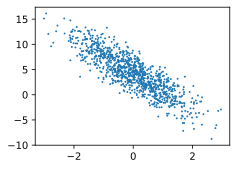

In [22]:
import torch 
from torch import nn
import random
from torch.utils import data
from d2l import torch as d2l

def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])

# 绘图，查看分布
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), 
                labels.detach().numpy(), 1);

In [24]:
# 读取数据
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 定义模型
net = nn.Sequential(nn.Linear(2, 1))
# 定义损失函数
loss_fn = nn.MSELoss()
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# 训练
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        y_hat = net(X)                  # 计算预测值
        loss = loss_fn(y_hat ,y)        # 根据预测值和真实值计算损失
        trainer.zero_grad()             # pytorch不能自动进行清零，所以手动进行
        loss.backward()                 # 损失自动反向传播
        trainer.step()                  # 优化器自动跟新参数
    loss = loss_fn(net(features), labels)
    print(f'epoch {epoch + 1}, loss {loss:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000150
epoch 2, loss 0.000095
epoch 3, loss 0.000095
epoch 4, loss 0.000095
epoch 5, loss 0.000095
epoch 6, loss 0.000096
epoch 7, loss 0.000095
epoch 8, loss 0.000096
epoch 9, loss 0.000094
epoch 10, loss 0.000096
w的估计误差： tensor([-0.0002, -0.0008])
b的估计误差： tensor([-0.0009])


#### 2.1.1.3. <a id='toc2_1_1_3_'></a>[predicted](#toc0_)

### 2.1.2. <a id='toc2_1_2_'></a>[断点续训](#toc0_)

### 2.1.5. <a id='toc2_1_5_'></a>[专题-损失函数](#toc0_)
#### 2.1.5.1. <a id='toc2_1_5_1_'></a>[均绝对值误差-l1 loss](#toc0_)

#### 2.1.5.2. <a id='toc2_1_5_2_'></a>[均方误差-l2 loss](#toc0_)

#### 2.1.5.3. <a id='toc2_1_5_3_'></a>[交叉熵](#toc0_)

#### 2.1.5.4. <a id='toc2_1_5_4_'></a>[自定义](#toc0_)

### 2.1.6. <a id='toc2_1_6_'></a>[专题-优化器](#toc0_)

#### 2.1.6.1. <a id='toc2_1_6_1_'></a>[梯度下降](#toc0_)

#### 2.1.6.2. <a id='toc2_1_6_2_'></a>[adagrad](#toc0_)

#### 2.1.6.3. <a id='toc2_1_6_3_'></a>[RMSProp](#toc0_)

# 3. <a id='toc3_'></a>[卷积神经网络-CNN](#toc0_)
```
CBAPD: 卷积，批量归一化，激活，池化，丢弃
卷积层就是特征提取，随后将特征传入FC（全连接层）；
卷积本身是线性的，但是经过激活函数后可以编程非线性的。
```

## 3.1. <a id='toc3_1_'></a>[LeNet5](#toc0_)

# 4. <a id='toc4_'></a>[循环神经网络-RNN](#toc0_)

## 简单RNN

## 4.1. <a id='toc4_1_'></a>[LSTM](#toc0_)

## 4.2. <a id='toc4_2_'></a>[GRU](#toc0_)

# 5. <a id='toc5_'></a>[注意力机制](#toc0_)

## 5.1. <a id='toc5_1_'></a>[Transformer](#toc0_)